In [1]:
import numpy as np
import pandas as pd

from itertools import cycle

import rpy2
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import IntVector, FloatVector
from rpy2.robjects.packages import importr

import math
from scipy import stats
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
from sklearn.metrics import roc_curve, auc, f1_score, cohen_kappa_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_recall_curve, make_scorer
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report
from sklearn.calibration import CalibratedClassifierCV

from sklearn.inspection import permutation_importance

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import font_manager as fm, rcParams
from matplotlib import get_cachedir
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

import shap
shap.initjs()

import os, re, glob, sys
import string
import pickle as pkl
import gzip

import warnings
warnings.filterwarnings('ignore')

%config Completer.use_jedi = False

In [2]:
font_dirs = [os.path.join(rcParams["datapath"], "fonts/ttf/Helvetica.ttf")]
font_files = fm.findSystemFonts(fontpaths=font_dirs)
font_list = fm.createFontList(font_files)
fm.fontManager.ttflist.extend(font_list)
mpl.rcParams['font.family'] = 'Helvetica'
# prop = fm.FontProperties(fname=os.path.join(rcParams["datapath"], "fonts/ttf/Helvetica.ttf"))
# plt.rcParams['font.family'] = prop.get_name()
print (plt.rcParams['font.family'])

['Helvetica']


In [3]:
def do_impute_with_median(df) :
    for i, col in enumerate(df.columns[df.isnull().any()]) :
        try :
            med = df[col].median()
        except :
            med = df[col].value_counts().index[0]
        df[col].fillna(value=med, inplace=True)
    return df


def do_dummy(df:pd.DataFrame, cols:list)->pd.DataFrame:    
    # categorical variable one hotcode 변수로 변환 (ordinal categorical variable은 연속변수로 취급)
    # missing value 있는 경우 어떻게 작동할지 테스트 해 보지 않았음
    # ordinal categorical variable이 아닌 categorical variable 값은 문자형태로 들어와야 새로운 변수를 만들 수 있음
    con_cols = list(set(df.columns.tolist()) - set(cols))
    dummy_df = pd.DataFrame()
    for col in cols:
        rename_dict = dict(zip(pd.get_dummies(df[col], drop_first=True).columns.tolist(), 
                           [' '.join(col.split("_"))+' '+str(x) \
                            for x in pd.get_dummies(df[col], drop_first=True).columns.tolist()]))
        if dummy_df.empty == True :
            dummy_df = pd.get_dummies(df[col], drop_first=True).rename(columns = rename_dict)
        else :
            dummy_df = pd.concat([dummy_df, pd.get_dummies(df[col], drop_first=True)\
                                                       .rename(columns = rename_dict)], axis=1)
        

    dummy_new_columnnames = ['_'.join(x.split(' ')) for x in dummy_df.columns.tolist()]
    dummy_df.columns = dummy_new_columnnames
    outdf = pd.concat([df[con_cols], dummy_df], axis=1)
    return outdf



def normalize(df, column_list):
    result = df.copy()
    for feature_name in column_list:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [4]:
df = pd.read_csv('planB_tabular_mimic4.csv')
print(df.shape, df[df['age'].notnull()].shape)
# df['OUTCLASS2'] =  df['OUTCLASS3'].apply(lambda x: 0 if x==0 else 1)
df = do_impute_with_median(df)
print(df.shape, df[df['age'].notnull()].shape)
# df['BMI'] = df['weight'] / (df['height']/100)**2
df.head()

(23242, 53) (23242, 53)
(23242, 53) (23242, 53)


,subject_id,hadm_id,stay_id,intub_duration,mortality14,OUTCLASS2,age,sex,height,weight,...,diabetes_without_cc,diabetes_with_cc,paraplegia,renal_disease,malignant_cancer,severe_liver_disease,metastatic_solid_tumor,aids,sapsii,sofa
0,18106347,24305596,30588857,0.138889,0,0,48,F,166.37,96.2,...,0,0,0,0,0,0,0,0,20.0,0.0
1,17195991,23542772,38319097,1.291667,0,0,61,F,170.18,110.0,...,0,0,0,0,0,0,0,0,39.0,0.0
2,16284044,23864737,36817845,0.166667,0,0,61,F,170.18,98.0,...,0,0,0,0,0,0,0,0,44.0,0.0
3,13201095,28453791,39953418,5.708333,1,1,88,F,162.56,71.9,...,0,0,0,1,0,0,0,0,82.0,1.0
4,12770182,20446666,34901199,1.347917,0,0,53,M,177.80,119.0,...,0,0,0,0,0,0,0,0,59.0,2.0


In [5]:
multilevel_cat_vars = ['sex','insurance_bin', 'language_bin', 'marital_status_bin', 
                       'admissiontype_score', 'ethnicity_penta', 'careunit_penta']
features = df.drop(columns=['subject_id', 'hadm_id', 'stay_id', 'OUTCLASS2', 
                            'intub_duration', 'mortality14', 'sapsii', 'sofa']).columns.tolist()
contin_vars = list(set(features)-set(multilevel_cat_vars))
print(df.shape, df[df['age'].notnull()].shape)
data = do_dummy(df, multilevel_cat_vars)
print(data.shape, data[data['age'].notnull()].shape)
data = normalize(data, contin_vars)
print(data.shape, data[data['age'].notnull()].shape)
data.head()

(23242, 53) (23242, 53)
(23242, 58) (23242, 58)
(23242, 58) (23242, 58)


,renal_disease,gcs_eye,T,peripheral_vascular_disease,severe_liver_disease,intub_duration,Anion_gap,myocardial_infarct,paraplegia,Albumin,...,language_bin_Other,marital_status_bin_Single,admissiontype_score_6,admissiontype_score_8,ethnicity_penta_Black,ethnicity_penta_Hispanic,ethnicity_penta_Others,ethnicity_penta_White,careunit_penta_Others,careunit_penta_Surgery_
0,0.0,0.000000,0.779026,0.0,0.0,0.138889,0.205128,0.0,0.0,0.5,...,0,1,0,1,0,0,0,1,0,1
1,0.0,0.000000,0.891386,0.0,0.0,1.291667,0.358974,0.0,0.0,0.5,...,0,1,1,0,0,0,0,1,0,1
2,0.0,0.000000,0.823970,0.0,0.0,0.166667,0.282051,1.0,0.0,0.5,...,0,1,0,1,0,0,0,1,0,1
3,1.0,0.666667,0.913483,1.0,0.0,5.708333,0.564103,1.0,0.0,0.5,...,0,1,1,0,0,0,0,1,0,0
4,0.0,1.000000,0.880150,0.0,0.0,1.347917,0.256410,0.0,0.0,0.5,...,0,0,1,0,0,0,0,1,0,0


In [6]:
data.columns

Index(['renal_disease', 'gcs_eye', 'T', 'peripheral_vascular_disease',
       'severe_liver_disease', 'intub_duration', 'Anion_gap',
       'myocardial_infarct', 'paraplegia', 'Albumin', 'Bilirubin', 'OUTCLASS2',
       'congestive_heart_failure', 'weight', 'dementia', 'rheumatic_disease',
       'stay_id', 'age', 'mild_liver_disease', 'gcs_motor', 'sapsii',
       'diabetes_without_cc', 'hadm_id', 'WBC', 'peptic_ulcer_disease',
       'Bicarbonate', 'NL_RATIO', 'cerebrovascular_disease',
       'malignant_cancer', 'BUN', 'pH', 'chronic_pulmonary_disease',
       'Potassium', 'aids', 'Creatinine', 'mortality14', 'subject_id',
       'height', 'Prothrombin_time_inr', 'Sodium', 'Hemoglobin', 'Lactate',
       'Platelets', 'diabetes_with_cc', 'metastatic_solid_tumor', 'sofa',
       'sex_M', 'insurance_bin_Public', 'language_bin_Other',
       'marital_status_bin_Single', 'admissiontype_score_6',
       'admissiontype_score_8', 'ethnicity_penta_Black',
       'ethnicity_penta_Hispanic', '

In [7]:
class0, class1= np.bincount(df['OUTCLASS2'])
total = class0+class1
print('Examples:\n\tTotal: {}\n\tClass 0: {} ({:.2f}%)\n\tClass 1: {} ({:.2f}%)\n'.format(
    total, class0, 100 * class0 / total, class1, 100 * class1 / total))

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / class0) * (total / 3.0)
weight_for_1 = (3 / class1) * (total / 3.0) 
# weight_for_2 = (1 / class2) * (total / 3.0)

class_weights = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Examples:
	Total: 23242
	Class 0: 19025 (81.86%)
	Class 1: 4217 (18.14%)

Weight for class 0: 0.41
Weight for class 1: 5.51


In [8]:
def adjusted_classes(y_scores, thr):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= thr else 0 for y in y_scores]


def plot_mean_confusion_matrix(clfs, thr, xtests, ytests, classes) :
    cms = []
    for i in range(len(xtests)) :
        ypred = clfs[i].predict_proba(xtests[i])
#         ypred = ypred.astype(np.int)

        cm = confusion_matrix(ytests[i], adjusted_classes(ypred[:,1], thr))
        cms.append(cm)
        
#     print(np.asarray(cms))
#     print(np.std(np.asarray(cms), axis=0))
        
    new_mean_array = np.array(["{:d}".format(int(x)) for x in np.mean(np.asarray(cms), axis=0)\
                                 .reshape(np.mean(np.asarray(cms), axis=0).size)])
    new_std_array = np.array(["$\pm${:.1f}".format(x) for x in np.std(np.asarray(cms), axis=0)\
                                 .reshape(np.std(np.asarray(cms), axis=0).size)])
    full = np.char.add(new_mean_array, new_std_array).reshape(2, 2)
    fig = plt.figure(figsize=(6, 6))
    fig.patch.set_facecolor('white')
    ax = plt.gca()
    im = ax.imshow(np.mean(np.asarray(cms), axis=0), interpolation='nearest', 
                   cmap=plt.cm.Blues)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks) 
    ax.set_xticklabels(classes, fontsize=11)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes, fontsize=11)

    for i in range(full.shape[0]):
        for j in range(full.shape[1]):
            ax.text(j, i, full[i, j],
                     horizontalalignment="center",
                     verticalalignment="center", fontsize=12,
                     color="white" if cm[i, j] > 1000 else "black")
    
    
    
    ax.set_title('Confusion Matrix', fontsize=12)
    ax.set_ylabel('Actual Values', fontsize=12)
    ax.set_xlabel('Predicted Values', fontsize=12)
    plt.tight_layout()
    pp = PdfPages('Figures/ConfusionMatrix.pdf')
    pp.savefig(fig)
    pp.close()
#     plt.savefig('Figures/Figure3.tif', bbox_inches="tight", dpi=1200, format='tiff', 
#             pil_kwargs={"compression": "tiff_lzw"})

In [9]:
def plot_roc(clf, xtest, ytest, n_classes=3) :

    y_pred = clf.predict_proba(xtest)
    y_test = label_binarize(ytest, classes=range(n_classes))#[0, 1])
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):#(0, 3, 1):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    lw = 1.5
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(8, 6.5))
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["tab:green", "tab:orange", "tab:blue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate", fontsize=13)
    plt.ylabel("True Positive Rate", fontsize=13)
    plt.title("Receiver operating characteristic to Survival(0) / Prolonged MV(1) / Death(2)", fontsize=13)
    plt.legend(loc="lower right", fontsize=13)
    plt.tick_params(axis='both', which='major', labelsize=13)
    plt.show()

In [10]:
lr_params = {'C': np.logspace(-3,3,10), 
            'penalty':['l2'], 
            'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga'],
            'random_state': [3766],
            'max_iter': [2000],
            'fit_intercept': [True],
            'tol': [0.5e-3, 1e-4, 1e-5, 1e-6], 
            'class_weight': [class_weights]
            }

rf_params = {'criterion': ('gini', 'entropy'), 
            'n_estimators': np.arange(50, 1500, 100), 
            #'max_depth': [6, 9, 12], 
            #'min_samples_leaf': [3, 6, 9], 
            #'min_samples_split': [3, 6, 9, 12],
            'random_state': [3766],
            #'max_features': ['log2'],
            'class_weight': [class_weights]
            }


cbc_params = {'nan_mode':['Min'], 
              'eval_metric': ['Logloss'], 
              'iterations': [1000], 
              'sampling_frequency': ['PerTree'], 
              'leaf_estimation_method': ['Newton'], 
              'grow_policy': ['SymmetricTree'],
              'penalties_coefficient': [1], 
              'boosting_type': ['Plain'], 
              'model_shrink_mode': ['Constant'], 
              'feature_border_type': ['GreedyLogSum'], 
#               'bayesian_matrix_reg': [0.10000000149011612], 
#               'force_unit_auto_pair_weights': [False], 
              'l2_leaf_reg': [3], 
              'random_strength': [1], 
              'rsm': [1], 
              'boost_from_average': [False], 
              'model_size_reg': [0.5], 
#               'pool_metainfo_options': [{'tags': {}}],
              'subsample': [0.800000011920929], 
              'use_best_model': [False], 
#               'class_names': [0, 1], 
#               'random_seed': [3766], 
              'depth': [6], 
              'posterior_sampling': [False], 
              'border_count': [254], 
              'class_weights': [class_weights],
              'classes_count': [0], 
              'auto_class_weights': ['None'], 
              'sparse_features_conflict_fraction': [0], 
              'leaf_estimation_backtracking': ['AnyImprovement'], 
              'best_model_min_trees': [1], 
              'model_shrink_rate': [0], 
              'min_data_in_leaf': [1], 
              'loss_function': ['Logloss'], 
              'learning_rate': [0.036584001034498215], 
              'score_function': ['Cosine'], 
              'task_type': ['CPU'], 
              'leaf_estimation_iterations': [10], 
              'bootstrap_type': ['MVS'], 
              'max_leaves': [64]}

In [11]:
X = data.drop(columns=['subject_id', 'hadm_id', 'stay_id', 'intub_duration', 'mortality14', 
                       'OUTCLASS2', 'sapsii', 'sofa'])
y = data['OUTCLASS2']
SAPSII = data['sapsii']
SOFA = data['sofa']
rlr_clfs = []
# qda_clfs = []
# gnb_clfs = []
rf_clfs = []
cb_clfs = []
en_clfs = []
X_tests = []
y_tests = []
sapsii_tests = []
sofa_tests = []

kappa_scorer = make_scorer(cohen_kappa_score)
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
for train_index, test_index in sss.split(X, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # sapsii
    sapsii_train, sapsii_test = SAPSII[train_index], SAPSII[test_index]
    sapsii_tests.append(sapsii_test)
    
    # sofa 
    sofa_train, sofa_test = SOFA[train_index], SOFA[test_index]
    sofa_tests.append(sofa_test)
    
    # Regularized logistic regression classifier
    print('rlrc training')
    rlr_grid = GridSearchCV(LogisticRegression(random_state=3766, class_weight=class_weights, verbose=0),
                           lr_params, scoring=kappa_scorer, 
                           cv=StratifiedKFold(), n_jobs=24, pre_dispatch="2*n_jobs")
    rlr_gridcv = rlr_grid.fit(X_train, y_train)
    best_rlr_params = rlr_gridcv.best_estimator_.get_params()
    rlrc = LogisticRegression(**best_rlr_params).fit(X_train, y_train)
#     rlrc = LogisticRegression().fit(X_train, y_train)
    rlrc = CalibratedClassifierCV(rlrc, cv=StratifiedKFold(), method='isotonic')
    rlrc.fit(X_train, y_train)
    
#     # Quadratic Discriminant Analysis
#     qdac = QuadraticDiscriminantAnalysis()
#     print('Quadratic Discriminant Analysis training')
#     qdac = CalibratedClassifierCV(qdac, cv=StratifiedKFold(), method='isotonic')
#     qdac.fit(X_train, y_train)
    
#     # Gaussian Naive Bayes
#     gnbc = GaussianNB()
#     print('Gaussian Naive Bayes training')
#     qnbc = CalibratedClassifierCV(gnbc, cv=StratifiedKFold(), method='isotonic')
#     qnbc.fit(X_train, y_train)
    
    # Random Forest classifer
    print('rfc training')
    rf_grid = GridSearchCV(RandomForestClassifier(random_state=3766, class_weight=class_weights, verbose=0),
                           rf_params, scoring=kappa_scorer, 
                           cv=StratifiedKFold(), n_jobs=24, pre_dispatch="2*n_jobs")
    rf_gridcv = rf_grid.fit(X_train, y_train)
    best_rf_params = rf_gridcv.best_estimator_.get_params()
    rfc = RandomForestClassifier(**best_rf_params)
    rfc = CalibratedClassifierCV(rfc, cv=StratifiedKFold(), method='isotonic')
    rfc.fit(X_train, y_train)
    
    # Catboost classifier
    print('cbc training')
    cbc_grid = GridSearchCV(CatBoostClassifier(random_state=3766, class_weights=class_weights, verbose=0),
                           cbc_params, scoring=kappa_scorer, cv=StratifiedKFold(), 
                           n_jobs=24, pre_dispatch="2*n_jobs")
    cbc_randcv = cbc_grid.fit(X_train, y_train)
    best_cbc_params = cbc_randcv.best_estimator_.get_params()
    best_cbc_params['class_weights'] = class_weights
#     cbc = CatBoostClassifier(random_state=3766, class_weights=class_weights, verbose=0)
    cbc = CatBoostClassifier(**best_cbc_params)
    cbc = CalibratedClassifierCV(cbc, cv=StratifiedKFold(), method='isotonic')
    cbc.fit(X_train, y_train)
#     vc = VotingClassifier(estimators=[('rlrc', rlrc), ('qdac', qdac), ('gnbc', gnbc), ('rfc', rfc), ('cbc', cbc)],
    vc = VotingClassifier(estimators=[('rlrc', rlrc), ('rfc', rfc), ('cbc', cbc)],
                          voting='soft', weights=[1, 1, 3], flatten_transform=False)
    vc.fit(X_train, y_train)
    
    rlr_clfs.append(rlrc)
#     qda_clfs.append(qdac)
#     gnb_clfs.append(gnbc)
    rf_clfs.append(rfc)
    cb_clfs.append(cbc)
    en_clfs.append(vc)
    X_tests.append(X_test)
    y_tests.append(y_test)

rlrc training
rfc training
cbc training
rlrc training
rfc training
cbc training
rlrc training
rfc training
cbc training
rlrc training
rfc training
cbc training
rlrc training
rfc training
cbc training


### Summarizing  Confusion matrix of 5 fold cross validation

In [12]:
def classification_report_summary(clfs, thr, X_tests, y_tests, target_names) :
    kappas = []
    reports = []
    for i, clf in enumerate(clfs) :
        ypred = clf.predict_proba(X_tests[i])
        kappas.append(cohen_kappa_score(y_tests[i], adjusted_classes(ypred[:,1], thr)))
        report_dict = classification_report(y_tests[i], adjusted_classes(ypred[:,1], thr),
                                            target_names=target_names, output_dict=True)
        reports.append(report_dict)
    
    for i, target in enumerate(target_names) :
        print(target)
        for metric in ['precision', 'recall', 'f1-score'] :
            _scores = []
            for j in range(len(reports)) :
                _scores.append(reports[j][target][metric])
            _scores = np.asarray(_scores)
            print(metric, ":", f"{np.mean(_scores):.3f}"f" +/- {np.std(_scores):.3f}")
        print()
    kappas = np.asarray(kappas)
    print()
    print("Cohen's kappa: "f"{np.mean(kappas):.3f}"f" +/- {np.std(kappas):.3f}")

0.31
Successful weaning 
$\leq$ 2 weeks
precision : 0.912 +/- 0.002
recall : 0.874 +/- 0.004
f1-score : 0.892 +/- 0.001

Failure to wean
 or death
precision : 0.521 +/- 0.005
recall : 0.618 +/- 0.012
f1-score : 0.565 +/- 0.005


Cohen's kappa: 0.459 +/- 0.006


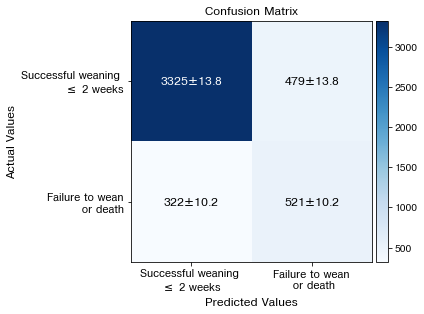

In [13]:
thr = 0.31
print(thr)
plot_mean_confusion_matrix(en_clfs, thr, X_tests, y_tests, ['Successful weaning \n$\leq$ 2 weeks',
                                                            'Failure to wean\n or death'])
classification_report_summary(en_clfs, thr, X_tests, y_tests, ['Successful weaning \n$\leq$ 2 weeks',
                                                            'Failure to wean\n or death'])

### Cohen's kappa between CBC and RFC

In [14]:
def class_agreement(clfs_a, clfs_b, xtests, thr_a, thr_b) :
    agreements = []
    for i in range(len(xtests)) :
        ypred_a = clfs_a[i].predict_proba(xtests[i])
        ypred_b = clfs_b[i].predict_proba(xtests[i])
        agreements.append(cohen_kappa_score(adjusted_classes(ypred_a[:,1], thr_a), 
                                            adjusted_classes(ypred_b[:,1], thr_b)))
    print(np.mean(agreements), np.std(agreements))

In [15]:
class_agreement(rf_clfs, cb_clfs, X_tests, 0.32, 0.30)

0.8028789207089883 0.024202854386835438


### Plotting AUROC and AUPRC of 5 fold cross validation

In [16]:
def adjusted_classes(y_scores, thr):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= thr else 0 for y in y_scores]


def tidy(x, n):
    """Return 'x' rounded to 'n' significant digits."""
    y=abs(x)
    if y <= sys.float_info.min: return 0.0
    return round( x, int( n-math.ceil(math.log10(y)) ) )

def mean_confidence_interval(data, lb = " ", confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return str(tidy(m,3))+ lb +"("+str(tidy(m-h,3))+\
           " – "+str(format(tidy(m+h,3), ".3f")+")")


def pr_summary(recall_model, prec_model) :
    
    prdf = pd.DataFrame(columns = ['recall', 'precision'])
    for recall, prec in zip(recall_model, prec_model) :
        dict_tmp = {'recall': recall, 'precision':prec}
        df_tmp = pd.DataFrame(dict_tmp)
        if prdf.empty == True :
            prdf = df_tmp.copy()
        else :
            prdf = pd.concat([prdf, df_tmp], ignore_index=True)
            
    pr_stats = pd.DataFrame(columns = ['recall', 'prec_loweriqr', 'prec_median', 'prec_upperiqr'])        
    recall_span = np.linspace(0, 1, 101)
    for i in range(recall_span.shape[0]-1) :
        if i != recall_span.shape[0]-1 :
            pr_stats.loc[len(pr_stats)] = [(recall_span[i] +recall_span[i+1])/2] + \
                                          prdf[(prdf['recall']>=recall_span[i]) & \
                                               (prdf['recall']<recall_span[i+1])]['precision']\
                                              .quantile([0.25, 0.5, 0.75]).to_list()
                                               
        else :
            pr_stats.loc[len(pr_stats)] = [(recall_span[i] +recall_span[i+1])/2] + \
                                          prdf[(prdf['recall']>=recall_span[i]) & \
                                               (prdf['recall']<=recall_span[i+1])]['precision']\
                                              .quantile([0.25, 0.5, 0.75]).to_list()
    return pr_stats.dropna(subset=['prec_loweriqr', 'prec_median', 'prec_upperiqr'])

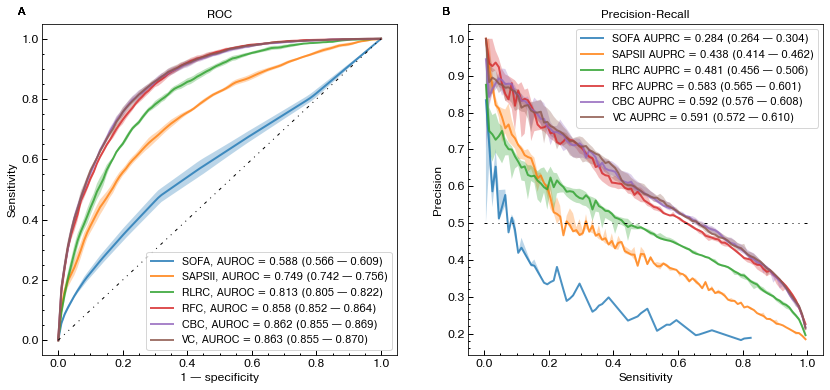

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6.1))
fig.patch.set_facecolor('white')
base_fpr = np.linspace(0, 1, 101)
for name, clfs in zip(['SOFA', 'SAPSII', 'RLRC', 'RFC', 'CBC', 'VC'], 
                      [sofa_tests, sapsii_tests, rlr_clfs, rf_clfs, cb_clfs, en_clfs]) : 
    model_fprs = []
    model_tprs = []
    model_tpr_mores = []
    model_aucs = []
    model_precs = []
    model_recalls = []
    model_praucs = []
    for i in range(len(X_tests)) :
        if name in ['RLRC', 'RFC', 'CBC', 'VC'] :
            ypred = clfs[i].predict_proba(X_tests[i])
            fpr, tpr, thr = roc_curve(y_tests[i], ypred[:,1])
            prec, recall, _ = precision_recall_curve(y_tests[i], ypred[:,1])
            prauc = auc(recall, prec)
        else :
            fpr, tpr, thr = roc_curve(y_tests[i], clfs[i])
            prec, recall, _ = precision_recall_curve(y_tests[i], clfs[i])
            prauc = auc(recall, prec)
            
        aucs = auc(fpr, tpr)

        tpr_more = np.interp(base_fpr, fpr, tpr)
        tpr_more[0] = 0.0
        model_fprs.append(fpr)
        model_tprs.append(tpr)
        model_tpr_mores.append(tpr_more)
        model_aucs.append(aucs)
        
        model_precs.append(prec)
        model_recalls.append(recall)
        model_praucs.append(prauc)

    MODEL_tprs = np.array(model_tpr_mores)
    MODEL_aucs = np.array(model_aucs)
    MODEL_mean_tprs = MODEL_tprs.mean(axis=0)
    MODEL_std = MODEL_tprs.std(axis=0)
    MODEL_tprs_upper = np.minimum(MODEL_mean_tprs + MODEL_std, 1)
    MODEL_tprs_lower = MODEL_mean_tprs - MODEL_std
 

#     tpr_more = np.interp(base_fpr, fpr, tpr)
    ax1.plot(base_fpr, MODEL_mean_tprs, alpha=0.8, linestyle='solid', linewidth=2,
            label = name+', AUROC = {}'.format(mean_confidence_interval(MODEL_aucs)))
    ax1.fill_between(base_fpr, MODEL_tprs_lower, MODEL_tprs_upper, alpha=0.3)
    testy = y_tests[0]
    ns_probs = [0 for _ in range(len(testy))]
    ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
 

    model_pr_mst = pr_summary(model_recalls, model_precs)
    ax2.plot(model_pr_mst['recall'], model_pr_mst['prec_median'], label = name+' AUPRC = {}'\
             .format(mean_confidence_interval(model_praucs)), alpha=0.8, linestyle='solid', linewidth=2)
    ax2.fill_between(model_pr_mst['recall'], model_pr_mst['prec_loweriqr'], 
                     model_pr_mst['prec_upperiqr'], alpha=0.3)
    testy = y_tests[0]
    no_skill = len(testy[testy==0]) / len(testy)
    

    ax1.set_ylabel("Sensitivity", fontsize=12)
    ax1.set_xlabel("1 – specificity", fontsize=12)
    ax1.legend(loc='best', fontsize=11)
    ax1.set_title("ROC", fontsize=12)
    ax1.minorticks_on()
    ax1.tick_params(which='major', length=5, width=1, direction='in')
    ax1.tick_params(which='minor', length=2, width=1, direction='in')
    ax1.tick_params(labelsize = 12)
    ax1.spines['bottom'].set_color('black')
    ax1.spines['top'].set_color('black')
    ax1.spines['left'].set_color('black')
    ax1.spines['right'].set_color('black')
    ax1.text(-0.05, 1.05, 'A', transform=ax1.transAxes,
      fontsize=12, fontweight='bold', va='top', ha='right')
    ax1.grid(False)

    ax2.set_title("Precision-Recall", fontsize=12)
    ax2.set_ylabel("Precision", fontsize=12)
    ax2.set_xlabel("Sensitivity", fontsize=12)
    ax2.legend(loc='best', fontsize=11)
    ax2.minorticks_on()
    ax2.tick_params(which='major', length=5, width=1, direction='in')
    ax2.tick_params(which='minor', length=2, width=1, direction='in')
    ax2.tick_params(labelsize = 12)
    ax2.spines['bottom'].set_color('black')
    ax2.spines['top'].set_color('black')
    ax2.spines['left'].set_color('black')
    ax2.spines['right'].set_color('black')
    ax2.text(-0.05, 1.05, 'B', transform=ax2.transAxes,
      fontsize=12, fontweight='bold', va='top', ha='right')
    ax2.grid(False)
ax1.plot(ns_fpr, ns_tpr,  color='black', linestyle=(0, (3, 5, 1, 5, 1, 5)),
         linewidth=1, label='No Skill model predicting negative')
ax2.plot([0, 1], [0.5, 0.5], color='black', linestyle=(0, (3, 5, 1, 5, 1, 5)), 
         linewidth=1, label='No skill model predicting negative')

pp = PdfPages('Figures/Figure2.pdf')
pp.savefig(fig)
pp.close()
# plt.savefig('Figures/Figure2.tif', bbox_inches="tight", dpi=1200, format='tiff', 
#             pil_kwargs={"compression": "tiff_lzw"})

#### For Table2
- Reference of Delong: https://glassboxmedicine.com/2020/02/04/comparing-aucs-of-machine-learning-models-with-delongs-test/
- Reference of Rpy2: https://rpy2.github.io/doc/v2.9.x/html/introduction.html

In [18]:
def get_auc_pvalue_delong(response, model1_pred, model2_pred) :
    
    pROC = importr('pROC')

    R = rpy2.robjects.r
    response = IntVector(response)
    model1 = FloatVector(model1_pred)
    model2 = FloatVector(model2_pred)
    roc1 = R['roc'](response, model1)
    roc2 = R['roc'](response, model2)
    result = R['roc.test'](roc1, roc2, method="delong")
    return result.rx('p.value')[0][0]

In [19]:
base_fpr = np.linspace(0, 1, 101)
table2 = pd.DataFrame(columns=["Model", "AUROC", "p-value (vs SOFA)", "p-value (vs SAPSII)", 
                               "AUPRC", "Cohen's Kappa", "F1-score"])
for name, clfs in zip(['SOFA', 'SAPSII', 'RLRC', 'RFC', 'CBC', 'VC'], 
                      [sofa_tests, sapsii_tests, rlr_clfs, rf_clfs, cb_clfs, en_clfs]) : 
    pval_sofas = []
    pval_sapsiis = []
    model_fprs = []
    model_tprs = []
    model_tpr_mores = []
    model_aurocs = []
    model_precs = []
    model_recalls = []
    model_auprcs = []
    model_f1scores = []
    model_kappas = []
    for i in range(len(X_tests)) :
        if name in ['RLRC', 'RFC', 'CBC', 'VC'] :
            ypred = clfs[i].predict_proba(X_tests[i])[:, 1]
            
        else :
            ypred = clfs[i]
        
        fpr, tpr, thr = roc_curve(y_tests[i], ypred)
        prec, recall, _ = precision_recall_curve(y_tests[i], ypred)
        auprc = auc(recall, prec)
        pval_sofas.append(get_auc_pvalue_delong(y_tests[i], sofa_tests[i], ypred))
        pval_sapsiis.append(get_auc_pvalue_delong(y_tests[i], sapsii_tests[i], ypred))
        auroc = auc(fpr, tpr)
        J_youden = tpr - fpr
        thr_opt = thr[np.argmax(J_youden)]
        model_f1scores.append(f1_score(y_tests[i], adjusted_classes(ypred, thr_opt)))
        model_kappas.append(cohen_kappa_score(y_tests[i], adjusted_classes(ypred, thr_opt)))
        model_aurocs.append(auroc)
        model_auprcs.append(auprc)
        
    table2.loc[len(table2)] = [name, mean_confidence_interval(model_aurocs), np.mean(pval_sofas), 
                               np.mean(pval_sapsiis), mean_confidence_interval(model_auprcs), 
                               mean_confidence_interval(model_kappas), mean_confidence_interval(model_f1scores)]
    
table2['p-value (vs SOFA)'] = table2['p-value (vs SOFA)'].apply(lambda x: '< 0.001' if x<0.001 else x)
table2['p-value (vs SAPSII)'] = table2['p-value (vs SAPSII)'].apply(lambda x: '< 0.001' if x<0.001 else x)

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case =

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

In [20]:
table2.to_csv('Figures/Table2.csv', index=False)
table2

,Model,AUROC,p-value (vs SOFA),p-value (vs SAPSII),AUPRC,Cohen's Kappa,F1-score
0,SOFA,0.588 (0.566 – 0.609),1,< 0.001,0.284 (0.264 – 0.304),0.121 (0.0958 – 0.147),0.33 (0.311 – 0.349)
1,SAPSII,0.749 (0.742 – 0.756),< 0.001,1,0.438 (0.414 – 0.462),0.28 (0.263 – 0.297),0.451 (0.44 – 0.462)
2,RLRC,0.813 (0.805 – 0.822),< 0.001,< 0.001,0.481 (0.456 – 0.506),0.335 (0.317 – 0.354),0.501 (0.491 – 0.510)
3,RFC,0.858 (0.852 – 0.864),< 0.001,< 0.001,0.583 (0.565 – 0.601),0.399 (0.386 – 0.411),0.545 (0.537 – 0.552)
4,CBC,0.862 (0.855 – 0.869),< 0.001,< 0.001,0.592 (0.576 – 0.608),0.404 (0.373 – 0.435),0.55 (0.532 – 0.568)
5,VC,0.863 (0.855 – 0.870),< 0.001,< 0.001,0.591 (0.572 – 0.610),0.407 (0.379 – 0.434),0.551 (0.534 – 0.569)


### Summarizing Feature importances of 5 fold cross validation

In [21]:
# models_fic_sorted = {}
# CBC_coeff_mean = {}
# CBC_coeff_std = {}
# for name, clfs in zip(['RLRC', 'RFC', 'CBC', 'VC'], [rlr_clfs, rf_clfs, cb_clfs, en_clfs]) :
#     for i in range(len(X_tests)) :
#         r = permutation_importance(clfs[i], X_tests[i], y_tests[i], n_repeats=10, random_state=0)
#         if i == 0 :
#             fic_mean = r.importances_mean
#             fic_var = r.importances_std**2
#         else :
#             fic_mean += r.importances_mean
#             fic_var += r.importances_std**2

#     print('***** '+name+' model *****')
#     fic_mean /= len(en_clfs)
#     fic_std = np.sqrt(fic_var)/len(en_clfs)
#     for i in fic_mean.argsort()[::-1]:
#         if fic_mean[i] - 2 * fic_std[i] > 0:
#             if name == 'CBC' :
#                 CBC_coeff_mean[X_test.columns[i]] = fic_mean[i]
#                 CBC_coeff_std[X_test.columns[i]] = fic_std[i]
#             print(f"{X_test.columns[i]:<35}"
#                    f"{fic_mean[i]:.3f}"
#                    f" +/- {fic_std[i]:.3f}")
#     models_fic_sorted[name] = X_test.columns[fic_mean.argsort()[::-1]].tolist()
#     print("\n\n")

In [22]:
models_fic_sorted = {}
VC_coeff_mean = {}
VC_coeff_std = {}
for name, clfs in zip(['RLRC', 'RFC', 'CBC', 'VC'], [rlr_clfs, rf_clfs, cb_clfs, en_clfs]) :
    for i in range(len(X_tests)) :
        r = permutation_importance(clfs[i], X_tests[i], y_tests[i], n_repeats=10, random_state=0)
        if i == 0 :
            fic_mean = r.importances_mean
            fic_var = r.importances_std**2
        else :
            fic_mean += r.importances_mean
            fic_var += r.importances_std**2

    print('***** '+name+' model *****')
    fic_mean /= len(en_clfs)
    fic_std = np.sqrt(fic_var)/len(en_clfs)
    for i in fic_mean.argsort()[::-1]:
        if fic_mean[i] - 2 * fic_std[i] > 0:
            if name == 'VC' :
                VC_coeff_mean[X_test.columns[i]] = fic_mean[i]
                VC_coeff_std[X_test.columns[i]] = fic_std[i]
            print(f"{X_test.columns[i]:<35}"
                   f"{fic_mean[i]:.3f}"
                   f" +/- {fic_std[i]:.3f}")
    models_fic_sorted[name] = X_test.columns[fic_mean.argsort()[::-1]].tolist()
    print("\n\n")

***** RLRC model *****
Anion_gap                          0.005 +/- 0.001
Lactate                            0.005 +/- 0.001
admissiontype_score_6              0.004 +/- 0.001
pH                                 0.003 +/- 0.000
admissiontype_score_8              0.003 +/- 0.001
Albumin                            0.002 +/- 0.000
Bilirubin                          0.001 +/- 0.000
Prothrombin_time_inr               0.001 +/- 0.000
careunit_penta_Surgery_            0.001 +/- 0.000
mild_liver_disease                 0.001 +/- 0.000



***** RFC model *****
Lactate                            0.009 +/- 0.001
Anion_gap                          0.006 +/- 0.001
pH                                 0.004 +/- 0.001
BUN                                0.004 +/- 0.001
careunit_penta_Surgery_            0.003 +/- 0.000
T                                  0.003 +/- 0.001
Prothrombin_time_inr               0.003 +/- 0.000
gcs_motor                          0.003 +/- 0.000
cerebrovascular_disease           

In [25]:
len(['Lactate', 'Anion gap', 'Prothrombin\n time', 'Body\n temperature', 'BUN', 'pH', 'Cerebrovascular\n disease', 
     'GCS score\n (motor)', 'age',  'Medical\n admission', 'Surgical ICU', 'Total Bilirubin', 'Albumin',
     'Hemoglobin', 'GCS score\n (eye)', 'Creatinine', 'WBC count', 'Bicarbonate',  'Metastatic\n solid tumor', 
     'Malignancy', 'AIDS'])

21

[0.00920197892019789, 0.005050548505054852, 0.0040998064099806554, 0.0037900623790062446, 0.0037728543772854485, 0.0033598623359862453, 0.003248010324801043, 0.003243708324370838, 0.00299849429984943, 0.0029554742955474333, 0.002189718218971828, 0.0021294902129490234, 0.0019660141966014225, 0.0016734781673478217, 0.001570230157023016, 0.0012389761238976171, 0.0010755001075500158, 0.00103248010324801, 0.0008948160894816116, 0.0005936760593676095, 4.302000430200792e-05]


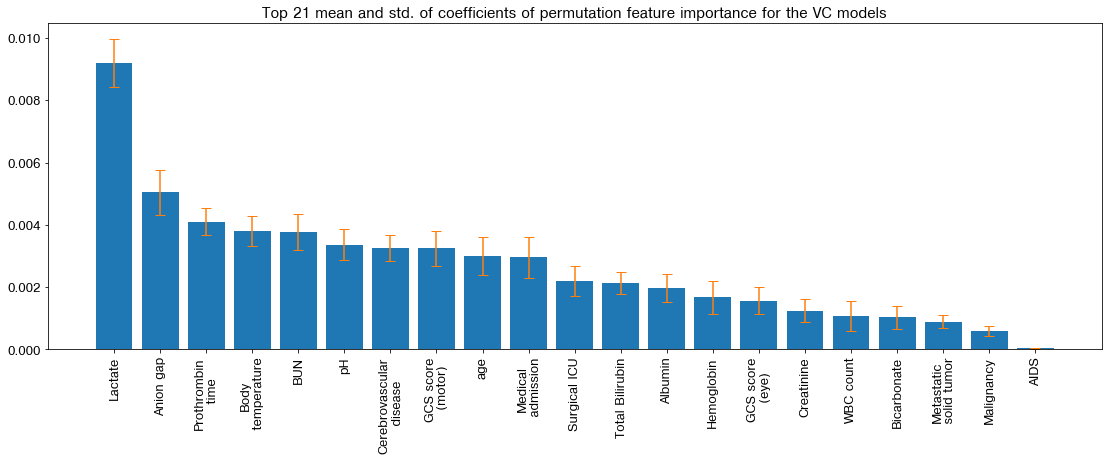

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(15.5, 6.5))
fig.patch.set_facecolor('white')
vc_coeff_mean = list(VC_coeff_mean.values())
vc_coeff_std = list(VC_coeff_std.values())
x_pos = list(vc_coeff_mean)
print (x_pos)
x_pos = ['Lactate', 'Anion gap', 'Prothrombin\n time', 'Body\n temperature', 'BUN', 'pH', 'Cerebrovascular\n disease', 
     'GCS score\n (motor)', 'age',  'Medical\n admission', 'Surgical ICU', 'Total Bilirubin', 'Albumin',
     'Hemoglobin', 'GCS score\n (eye)', 'Creatinine', 'WBC count', 'Bicarbonate',  'Metastatic\n solid tumor', 
     'Malignancy', 'AIDS']
         
ax.bar(x_pos, vc_coeff_mean, yerr=vc_coeff_std, align='center', color='tab:blue', 
       ecolor='tab:orange', capsize=5)
ax.tick_params(axis='x', rotation=90, labelsize=13)
ax.tick_params(axis='y', labelsize=13)
ax.set_title('Top 21 mean and std. of coefficients of permutation feature importance for the VC models',
             fontsize=15)
plt.tight_layout()
pp = PdfPages('Figures/Figure3.pdf')
pp.savefig(fig)
pp.close()
# plt.savefig('Figures/Figure4.tif', bbox_inches="tight", dpi=1200, format='tiff', 
#             pil_kwargs={"compression": "tiff_lzw"})

In [27]:
X.columns

Index(['renal_disease', 'gcs_eye', 'T', 'peripheral_vascular_disease',
       'severe_liver_disease', 'Anion_gap', 'myocardial_infarct', 'paraplegia',
       'Albumin', 'Bilirubin', 'congestive_heart_failure', 'weight',
       'dementia', 'rheumatic_disease', 'age', 'mild_liver_disease',
       'gcs_motor', 'diabetes_without_cc', 'WBC', 'peptic_ulcer_disease',
       'Bicarbonate', 'NL_RATIO', 'cerebrovascular_disease',
       'malignant_cancer', 'BUN', 'pH', 'chronic_pulmonary_disease',
       'Potassium', 'aids', 'Creatinine', 'height', 'Prothrombin_time_inr',
       'Sodium', 'Hemoglobin', 'Lactate', 'Platelets', 'diabetes_with_cc',
       'metastatic_solid_tumor', 'sex_M', 'insurance_bin_Public',
       'language_bin_Other', 'marital_status_bin_Single',
       'admissiontype_score_6', 'admissiontype_score_8',
       'ethnicity_penta_Black', 'ethnicity_penta_Hispanic',
       'ethnicity_penta_Others', 'ethnicity_penta_White',
       'careunit_penta_Others', 'careunit_penta_Surgery_'

In [28]:
model_save_path = './pickled'
kappas = [] 
f1s = []
aucs = []
accs = []
inclusion_feature_list = [3, 5, 7, 9, 12, 15, 18, 21, 25, 30, 35, 38, 42, 46, 50]
for n_include_features in inclusion_feature_list :
    _kappa = [] 
    _f1 = []
    _auc = []
    _acc = []
    X_cu = X.loc[:,models_fic_sorted['VC'][:n_include_features]]
    for train_index, test_index in sss.split(X_cu, y):
        X_train, X_test = X_cu.loc[train_index], X_cu.loc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Regularized logistic regression classifier
#         print('rlrc training')
        rlr_grid = GridSearchCV(LogisticRegression(random_state=3766, class_weight=class_weights, verbose=0),
                               lr_params, scoring=kappa_scorer, 
                               cv=StratifiedKFold(), n_jobs=48, pre_dispatch="2*n_jobs")
        rlr_gridcv = rlr_grid.fit(X_train, y_train)
        best_rlr_params = rlr_gridcv.best_estimator_.get_params()
        rlrc = LogisticRegression(**best_rlr_params).fit(X_train, y_train)
        rlrc = CalibratedClassifierCV(rlrc, cv=StratifiedKFold(), method='isotonic')
        rlrc.fit(X_train, y_train)

        # Random Forest classifer
#         print('rfc training')
        rf_grid = GridSearchCV(RandomForestClassifier(random_state=3766, class_weight=class_weights, verbose=0),
                               rf_params, scoring=kappa_scorer, 
                               cv=StratifiedKFold(), n_jobs=48, pre_dispatch="2*n_jobs")
        rf_gridcv = rf_grid.fit(X_train, y_train)
        best_rf_params = rf_gridcv.best_estimator_.get_params()
        rfc = RandomForestClassifier(**best_rf_params)
        rfc = CalibratedClassifierCV(rfc, cv=StratifiedKFold(), method='isotonic')
        rfc.fit(X_train, y_train)

        # Catboost classifier
#         print('cbc training')
        cbc_grid = GridSearchCV(CatBoostClassifier(random_state=3766, class_weights=class_weights, verbose=0),
                               cbc_params, scoring=kappa_scorer, cv=StratifiedKFold(), 
                               n_jobs=24, pre_dispatch="2*n_jobs")
        cbc_randcv = cbc_grid.fit(X_train, y_train)
        best_cbc_params = cbc_randcv.best_estimator_.get_params()
        best_cbc_params['class_weights'] = class_weights
        cbc = CatBoostClassifier(**best_cbc_params)
        cbc = CalibratedClassifierCV(cbc, cv=StratifiedKFold(), method='isotonic')

#         cbc = CatBoostClassifier(random_state=3766, class_weights=class_weights, verbose=0)
#         cbc = CalibratedClassifierCV(cbc, cv=StratifiedKFold(), method='sigmoid')
        cbc.fit(X_train, y_train)

        vc = VotingClassifier(estimators=[('rlrc', rlrc), ('rfc', rfc), ('cbc', cbc)],
                              voting='soft', weights=[1, 1, 3], flatten_transform=False)
        vc.fit(X_train, y_train)
        y_pred = vc.predict_proba(X_test)[:, 1]
        fpr, tpr, thr = roc_curve(y_test, y_pred)
        J_youden = tpr - fpr
        thr_opt = thr[np.argmax(J_youden)]
        y_ipred = adjusted_classes(y_pred, thr_opt)
        _auc.append(auc(fpr, tpr))
        _kappa.append(cohen_kappa_score(y_test, y_ipred))
        _f1.append(f1_score(y_test, y_ipred))
        _acc.append(balanced_accuracy_score(y_test, y_ipred))
    
    # Several metrics of VC model are save every iteration
    savefile_name = "vc_metrics"+str(n_include_features).zfill(2)+"feat.pkl"
    data_saving = {
        'features': models_fic_sorted['VC'][:n_include_features],
        'kappas':np.array(_kappa),
        'f1scores': np.array(_f1),
        'aucs': np.array(_auc),
        'accs': np.array(_acc)
    }
    print('N_include_features = {}, {}, metric results are saving'\
             .format(n_include_features, models_fic_sorted['VC'][:n_include_features]))
    with gzip.open(os.path.join(model_save_path, savefile_name), 'wb') as f:
        pkl.dump(data_saving, f)

    kappas.append(np.array(_kappa))
    f1s.append(np.array(_f1))
    aucs.append(np.array(_auc))
    accs.append(np.array(_acc))

N_include_features = 3, ['Lactate', 'Anion_gap', 'Prothrombin_time_inr'], metric results are saving
N_include_features = 5, ['Lactate', 'Anion_gap', 'Prothrombin_time_inr', 'T', 'BUN'], metric results are saving
N_include_features = 7, ['Lactate', 'Anion_gap', 'Prothrombin_time_inr', 'T', 'BUN', 'pH', 'cerebrovascular_disease'], metric results are saving
N_include_features = 9, ['Lactate', 'Anion_gap', 'Prothrombin_time_inr', 'T', 'BUN', 'pH', 'cerebrovascular_disease', 'gcs_motor', 'age'], metric results are saving
N_include_features = 12, ['Lactate', 'Anion_gap', 'Prothrombin_time_inr', 'T', 'BUN', 'pH', 'cerebrovascular_disease', 'gcs_motor', 'age', 'admissiontype_score_6', 'careunit_penta_Surgery_', 'Bilirubin'], metric results are saving
N_include_features = 15, ['Lactate', 'Anion_gap', 'Prothrombin_time_inr', 'T', 'BUN', 'pH', 'cerebrovascular_disease', 'gcs_motor', 'age', 'admissiontype_score_6', 'careunit_penta_Surgery_', 'Bilirubin', 'Albumin', 'Hemoglobin', 'gcs_eye'], metric

In [ ]:
# kappas = []
# f1s = []
# aucs = []
# accs = []
# feats = []
# pickle_files = glob.glob('./pickled/vc_metrics*feat.pkl')
# pickle_files.sort()
# for ifile in pickle_files :
#     with gzip.open(ifile,'rb') as f:
#         data = pkl.load(f)
#         feats.append(data['features'])
#         kappas.append(data['kappas'])
#         f1s.append(data['f1scores'])
#         aucs.append(data['aucs'])
#         accs.append(data['accs'])

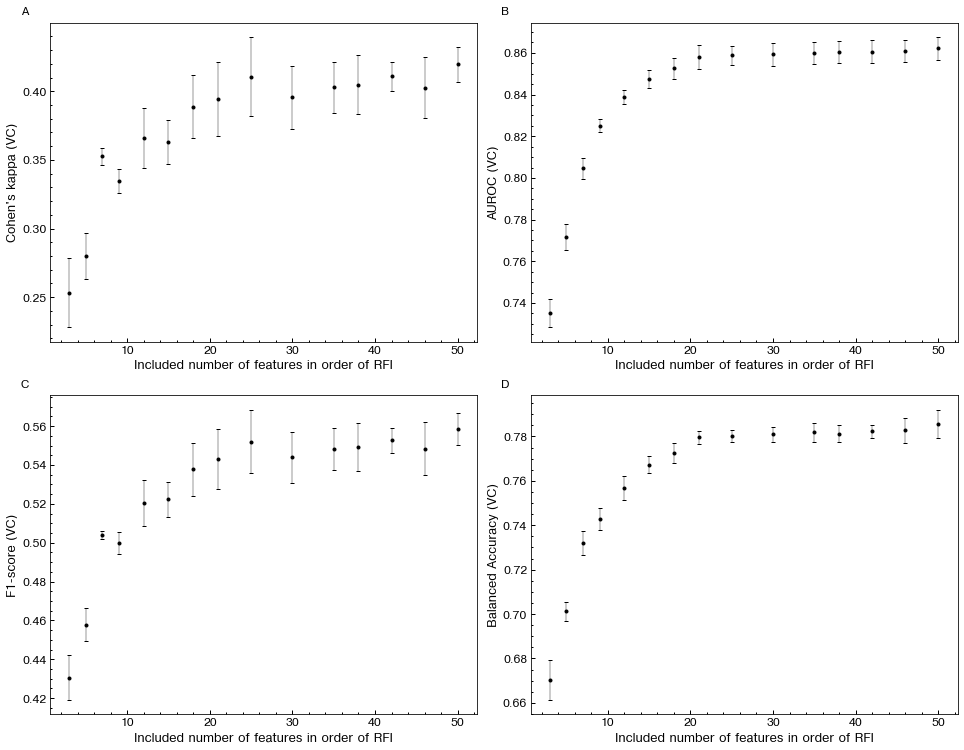

In [29]:
fig = plt.figure(figsize = (13.5, 10.5))
fig.subplots_adjust(wspace=0, hspace=0)
fig.patch.set_facecolor('white')
labelperfs = ["Cohen's kappa (VC)", "AUROC (VC)", "F1-score (VC)", 'Balanced Accuracy (VC)']
panel_labels = ['A', 'B', 'C', 'D']
# models = ["VC", "RF", "RLR"]
# subtitles = list(string.ascii_lowercase[0:10])
for j, arr in enumerate([kappas, aucs, f1s, accs]) :
    auc_y = np.mean(arr, axis = -1)[::-1]
    auc_e = np.std(arr, axis = -1)[::-1]
    ax = fig.add_subplot(2, 2, j+1)
    x = np.array(inclusion_feature_list)
    ax.errorbar(x[::-1], auc_y, auc_e, linestyle='None', marker='.', 
                color='k', elinewidth=0.4, capsize=2)
    ax.tick_params(labelsize = 12)
    ax.set_xlabel("Included number of features in order of RFI",
                  fontsize=13)
    ax.set_ylabel(labelperfs[int(j)], fontsize=13)
    ax.grid(False)
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.minorticks_on()
    ax.tick_params(which='major', length=4, width=1, direction='in')
    ax.tick_params(which='minor', length=2, width=1, direction='in')
    ax.text(-0.05, 1.05, panel_labels[j], transform=ax.transAxes,
      fontsize=12, fontweight='bold', va='top', ha='right')

plt.tight_layout()
pp = PdfPages('Figures/Figure4.pdf')
pp.savefig(fig)
pp.close()
# plt.savefig("Figures/Figure5.tif", bbox_inches="tight", dpi=1200, format='tiff', 
#             pil_kwargs={"compression": "tiff_lzw"})
# plt.show()

#### RLRC SHAP

In [ ]:
# explainer = shap.TreeExplainer(rlr_clfs[4])
# shap_values = explainer.shap_values(X_tests[4])
# shap.summary_plot(shap_values, X_tests[4])

#### RFC SHAP

In [ ]:
# explainer = shap.TreeExplainer(rf_clfs[4])
# shap_values = explainer.shap_values(X_tests[4])
# shap.summary_plot(shap_values, X_tests[4])

####  Ensemble SHAP

In [30]:
X_tests[2].columns.tolist()

['renal_disease',
 'gcs_eye',
 'T',
 'peripheral_vascular_disease',
 'severe_liver_disease',
 'Anion_gap',
 'myocardial_infarct',
 'paraplegia',
 'Albumin',
 'Bilirubin',
 'congestive_heart_failure',
 'weight',
 'dementia',
 'rheumatic_disease',
 'age',
 'mild_liver_disease',
 'gcs_motor',
 'diabetes_without_cc',
 'WBC',
 'peptic_ulcer_disease',
 'Bicarbonate',
 'NL_RATIO',
 'cerebrovascular_disease',
 'malignant_cancer',
 'BUN',
 'pH',
 'chronic_pulmonary_disease',
 'Potassium',
 'aids',
 'Creatinine',
 'height',
 'Prothrombin_time_inr',
 'Sodium',
 'Hemoglobin',
 'Lactate',
 'Platelets',
 'diabetes_with_cc',
 'metastatic_solid_tumor',
 'sex_M',
 'insurance_bin_Public',
 'language_bin_Other',
 'marital_status_bin_Single',
 'admissiontype_score_6',
 'admissiontype_score_8',
 'ethnicity_penta_Black',
 'ethnicity_penta_Hispanic',
 'ethnicity_penta_Others',
 'ethnicity_penta_White',
 'careunit_penta_Others',
 'careunit_penta_Surgery_']

In [31]:
df['admissiontype_score'].value_counts()

6    13625
8     8286
0     1331
Name: admissiontype_score, dtype: int64

In [32]:
display(X_tests[2]['admissiontype_score_6'].value_counts())
display(X_tests[2]['admissiontype_score_8'].value_counts())

1    2707
0    1942
Name: admissiontype_score_6, dtype: int64

0    2979
1    1670
Name: admissiontype_score_8, dtype: int64

In [33]:
for i in range(len(X_tests)) :
    X_tests[i].rename(columns={'age':'Age', 'careunit_penta_Surgery_':'Surgical ICU',
                               'sex':'Sex', 'careunit_penta_Others':'Others ICU',
                               'height':'Height', 'weight':'Weight', 
                               'gcs_eye':'GCS score (eye)', 'gcs_motor':'GCS score (motor)',
                               'Anion_gap':'Anion gap', 'insurance_bin_Public' : 'Public insurance',
                               'Bilirubin':'Total bilirubin', 'language_bin_Other':'Other language',
                               'Platelets':'Platelet count', 'marital_status_bin_Single':'Single',
                               'Prothrombin_time_inr':'Prothrombin time',
                               'NL_RATIO':'Neutrophil/lymphocyte ratio', 'WBC':'WBC count', 
                               'T':'Body temperature', 
                               'admissiontype_score_6':'Medical admission',
                               'admissiontype_score_8':'Unscheduled surgical admission',
                               'insurance_bin':'Type of insurance', 
                               'language_bin':'Primary language',
                               'marital_status_bin':'Marital status',
                               'ethnicity_penta':'Ethnicity', 'careunit_penta':'Type of ICU',
                               'myocardial_infarct':'Myocardial infarction',
                               'congestive_heart_failure':'Congestive heart failure',
                               'peripheral_vascular_disease':'Peripheral vascular disease',
                               'cerebrovascular_disease':'Cerebrovascular disease',
                               'dementia':'Dementia', 
                               'chronic_pulmonary_disease':'Chronic pulmonary disease',
                               'rheumatic_disease':'Rheumatic disease',
                               'peptic_ulcer_disease':'Peptic ulcer disease',
                               'mild_liver_disease':'Mild liver disease',
                               'diabetes_without_cc':'Diabetes without complication/comorbidity',
                               'diabetes_with_cc':'Diabetes with complication/comorbidity',
                               'paraplegia':'Paraplegia', 'renal_disease':'Renal disease',
                               'malignant_cancer':'Malignancy', 
                               'severe_liver_disease':'Severe liver disease',
                               'metastatic_solid_tumor':'Metastatic solid tumor',
                               'aids':'AIDS', 'sapsii':'SAPSII', 'sofa':'SOFA',
                               'ethnicity_penta_White':'White', 'ethnicity_penta_Black':'Black', 
                               'ethnicity_penta_Hispanic':'Hispanic', 
                               'ethnicity_penta_Others':'Other ethnicity'}, 
                     inplace=True)

In [34]:
shap_values_list = []
for i in range(2, 3) :
    explainer = shap.explainers.Permutation(cb_clfs[i].predict_proba, X_tests[i])
    shap_values = explainer(X_tests[i])
    shap_values_list.append(shap_values)

Permutation explainer: 4650it [2:32:15,  1.97s/it]                            


In [ ]:
shap_values = shap_values_list[0]
shap.plots.beeswarm(shap_values[...,1], max_display=25)

In [ ]:
shap_values = shap_values_list[1]
shap.plots.beeswarm(shap_values[...,1], max_display=25)

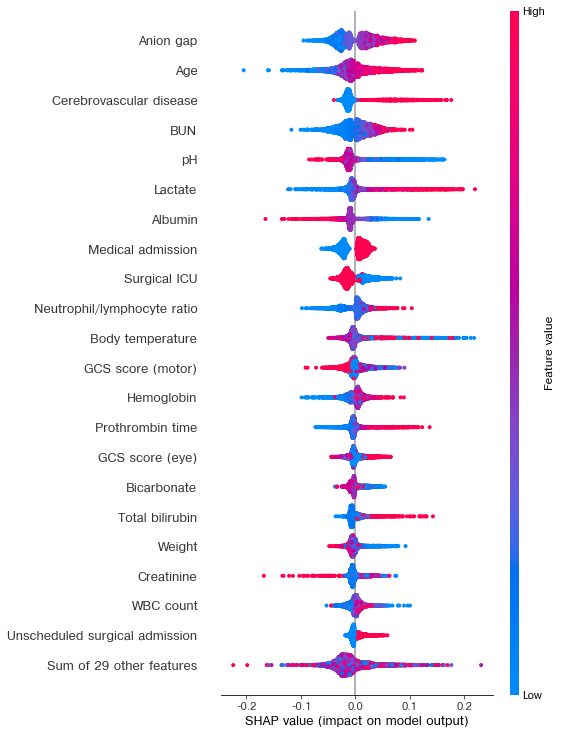

In [35]:
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
shap_values = shap_values_list[0]
shap.plots.beeswarm(shap_values[...,1], max_display=22, show=False)
plt.tight_layout()
pp = PdfPages('Figures/SHAP.pdf')
pp.savefig(fig)
pp.close()
# plt.savefig("Figures/FigureS.tif", bbox_inches="tight", dpi=1200, format='tiff', 
#             pil_kwargs={"compression": "tiff_lzw"})

In [ ]:
shap_values = shap_values_list[3]
shap.plots.beeswarm(shap_values[...,1], max_display=25)

In [ ]:
shap_values = shap_values_list[4]
shap.plots.beeswarm(shap_values[...,1], max_display=25)